In [1]:
import gc
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### **Algoritmos a probar**

**Linear**
* Logistic Regression
* Linear SVC (regularized - unregularized)

**Non-linear**
* Poly SVC
* rbf SVC

**otros**
* naïve Bayes
* Nearest Neighbors Classification
* Stochastic Gradient Descent
* Gaussian Process Classification
* Decision Trees

**Ensambles**
* Random Forests
* AdaBoost
* Gradient Tree Boosting

**Neural Network**
* Multi-layer Perceptron

### Pre-procesamiento de datos

In [2]:
%%time
# Cargo datos parte1
avisos_parte1 =  pd.read_csv('../data/datos_navent_fiuba/fiuba_6_avisos_detalle.csv')
postulaciones_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_4_postulaciones.csv')
vistas_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_3_vistas.csv')
edadYGenero_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv')
educacion_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_1_postulantes_educacion.csv')

# Cargo datos hasta 15_4
avisos_hasta15_4 =  pd.read_csv('./data/Fiuba hasta 15 Abril/fiuba_6_avisos_detalle.csv')
postulaciones_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_4_postulaciones.csv')
vistas_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_3_vistas.csv')
edadYGenero_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_2_postulantes_genero_y_edad.csv')
educacion_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_1_postulantes_educacion.csv')

# Concateno la info
avisos = pd.concat([avisos_parte1, avisos_hasta15_4])
postulaciones = pd.concat([postulaciones_parte1, postulaciones_hasta15_4])
vistas = pd.concat([vistas_parte1, vistas_hasta15_4])
edadYGenero = pd.concat([edadYGenero_parte1, edadYGenero_hasta15_4])
educacion = pd.concat([educacion_parte1, educacion_hasta15_4])

# Elimino las referencias a sets que ya no necesito
del(avisos_hasta15_4,
    avisos_parte1,
    postulaciones_hasta15_4,
    postulaciones_parte1,
    vistas_hasta15_4,
    vistas_parte1,
    edadYGenero_hasta15_4,
    edadYGenero_parte1,
    educacion_hasta15_4,
    educacion_parte1)
gc.collect()

# Guardo una lista con los datasets
data = [avisos, postulaciones, vistas, edadYGenero, educacion]

# Elimino duplicados
for df in data:
  if(df.duplicated().any().any()):
    df.drop_duplicates(inplace=True)

# Reseteo los index
for df in data:
  df.reset_index(drop=True, inplace=True)

# Remuevo columnas innecesarias
avisos.drop(columns=['idpais','ciudad','mapacalle'], inplace=True)

# Renombro columnas
educacion.rename(columns={'nombre':'nivel'}, inplace=True)
vistas.rename(columns={'idAviso':'idaviso','timestamp':'fechavista'}, inplace=True)

CPU times: user 1min 2s, sys: 5.31 s, total: 1min 7s
Wall time: 1min 7s


In [3]:
avisos.sample()

,idaviso,titulo,descripcion,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
19301,1112404132,Analista Funcional / Programador para Genexus,"<p><span style="""">Importante empresa banco / f...",Gran Buenos Aires,Full-time,Senior / Semi-Senior,Programación,HV Talent


In [4]:
edadYGenero.sample()

,idpostulante,fechanacimiento,sexo
117446,6rZmxAL,1986-11-18,MASC


In [5]:
educacion.sample()

,idpostulante,nivel,estado
350026,96MlqBa,Terciario/Técnico,Graduado


In [6]:
postulaciones.sample()

,idaviso,idpostulante,fechapostulacion
3993251,1112414497,2zP4ePV,2018-04-04 13:48:46


In [7]:
vistas.sample()

,idaviso,fechavista,idpostulante
444708,1112363768,2018-02-26T17:35:52.866-0500,QNaROBo


In [8]:
%%time
# Veo que set y columnas tiene datos faltantes
datos = {'avisos': avisos, 'postulaciones': postulaciones, 'vistas': vistas, 'edadYGenero': edadYGenero, 'educacion': educacion}
for name, df in datos.items():
  cols_con_nulls = df.isnull().any()
  print(f"[{name}]",cols_con_nulls.any())
  if cols_con_nulls.any():
    cols = df.columns[cols_con_nulls.values][0]
    print('  columnas ->',cols)
    for column in [cols]:
      print(f'  tasa[{column}]:', len(df[df[[column]].isnull().values])/len(df))
  print()

[avisos] True
  columnas -> denominacion_empresa
  tasa[denominacion_empresa]: 0.0003048006096012192

[postulaciones] False

[vistas] False

[edadYGenero] True
  columnas -> fechanacimiento
  tasa[fechanacimiento]: 0.04809377846111661

[educacion] False

CPU times: user 3.64 s, sys: 85.6 ms, total: 3.73 s
Wall time: 3.72 s


In [9]:
%%time
# AVISOS
# Analizo cols con nulls
if(avisos.isna().any().any()):
  cols_con_nulls = avisos.columns[avisos.isna().any().values]
  for col in cols_con_nulls:
    print(col)
    print(avisos[col].isna().value_counts())

# Elimino filas con datos faltantes
if(avisos.isna().any().any()):
  avisos.dropna(inplace=True)
  avisos.reset_index(drop=True, inplace=True)

denominacion_empresa
False    19679
True         6
Name: denominacion_empresa, dtype: int64
CPU times: user 88.1 ms, sys: 3.21 ms, total: 91.3 ms
Wall time: 89.1 ms


## AVISOS.DESCRIPCIÓN

In [10]:
%%time
# AVISOS.DESCRIPCIÓN
import re, string, unicodedata
# Funciones para extraer tags html, websites, números
def remove_tags(text):
  return re.sub(r'<[^>]+>',' ', text)
def remove_websites(text):
  return re.sub(r'(www|http)\S+', ' ', text)
def remove_numbers(text):
  return re.sub(r'[0-9]', ' ', text)
# Función para reemplazar diacríticos
#def replace_diacritics(text):
#  return unicodedata.normalize('NFKD',text).encode('ASCII', 'ignore').decode()

# Mapea signos (.,:!¡¿?@ etc) a None
# creo q no se necesita
#punctuation =  string.punctuation
#tr = str.maketrans(punctuation, ' '*len(punctuation))

# Remuevo tags html, caracteres especiales, espacios, diacríticos
avisos['descripcion'] = avisos.descripcion.apply(lambda w: remove_numbers(remove_tags(remove_websites(w)))\
                                                 #.translate(tr)\
                                                 #.replace('\r\n',' ')\
                                                 #.replace('\xa0',' ')\
                                                 .lower()\
                                                 .strip())
avisos.descripcion.sample()

CPU times: user 1.33 s, sys: 0 ns, total: 1.33 s
Wall time: 1.33 s


In [11]:
%%time
#from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer#, TfidfTransformer, HashingVectorizer
from stop_words import get_stop_words

# hay descripciones en español e inglés
stop_words = get_stop_words('es') + get_stop_words('en')

# Elegir uno HashingTrick/TF-IDF_Vectorizer
# n_features para elegir la cantidad de cols
#hash_vectorizer = make_pipeline(HashingVectorizer(), TfidfTransformer())
#X = hash_vectorizer.fit_transform(avisos.descripcion.values)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, norm='l2')
X = tfidf_vectorizer.fit_transform(avisos.descripcion.values)
print(X.shape)
#print(tfidf_vectorizer.vocabulary_)
#print(tfidf_vectorizer.idf_)

(19679, 33618)
CPU times: user 4.32 s, sys: 13.1 ms, total: 4.33 s
Wall time: 4.38 s


CPU times: user 22min 40s, sys: 2min 52s, total: 25min 33s
Wall time: 9min 40s


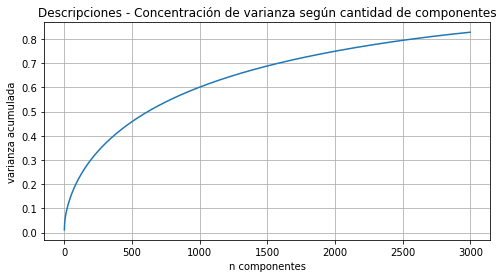

CPU times: user 22min 40s, sys: 2min 53s, total: 25min 34s
Wall time: 9min 41s


In [12]:
%%time
from sklearn.decomposition import TruncatedSVD# IncrementalPCA, PCA
# Veo con 3000 componentes como es la varianza
svd = TruncatedSVD(n_components=3000)
%time svd.fit(X)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('Descripciones - Concentración de varianza según cantidad de componentes')
plt.xlabel('n componentes')
plt.ylabel('varianza acumulada')
plt.grid()
plt.show()

In [13]:
%%time
# elijo este algoritmo porque acepta trabajar con scipy.sparse matrix
from sklearn.decomposition import TruncatedSVD
# Veo que 2000 features se concentran el 75% de la varianza
svd = TruncatedSVD(n_components=2000)
X = svd.fit_transform(X)
print(X.shape)

(19679, 2000)
CPU times: user 11min 18s, sys: 1min 47s, total: 13min 6s
Wall time: 5min 17s


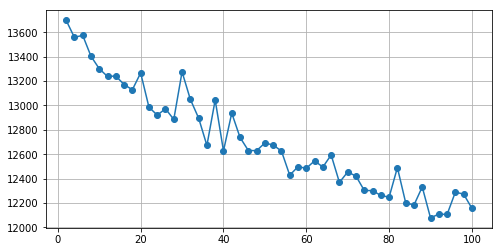

CPU times: user 15min 43s, sys: 6min 50s, total: 22min 33s
Wall time: 11min 35s


In [14]:
%%time
# Método del codo para encontrar el número de clusters ideal
# KMeans tarda mucho y según la doc MiniBatchKMeans da practicamente los mismos resultados
# AgglomerativeClustering no acepta matrices esparcidas
from sklearn.cluster import MiniBatchKMeans#, KMeans
clusters = range(2,101,2)# cada 2 para q no tarde tanto
costs = []
for n_clusters in clusters:
  model = MiniBatchKMeans(n_clusters=n_clusters, batch_size=2000, reassignment_ratio=0.0001)
  model.fit(X)
  costs.append(model.inertia_)
  #print('k:',n_clusters,'| cost:', model.inertia_)
plt.figure(figsize=(8,4))
plt.plot(clusters, costs, marker='o')
plt.grid(True)
plt.title('Descrición - Inercia según cantidad de clusters')
plt.xlabel('n clusters')
plt.ylabel('inercia')
plt.show()

In [15]:
n_clusters = 60

In [16]:
%%time
mbkm_model = MiniBatchKMeans(n_clusters=n_clusters, batch_size=2000, reassignment_ratio=0.0001)
mbkm_model.fit(X)

CPU times: user 21.9 s, sys: 7.8 s, total: 29.7 s
Wall time: 14.8 s


In [17]:
desc_dummies = pd.get_dummies(mbkm_model.labels_)
desc_dummies.rename(
  columns=(dict([(n,f'desc_{n+1}') for n in range(len(desc_dummies.columns))])),
  inplace=True)
avisos = pd.merge(avisos, desc_dummies, left_index=True,right_index=True).drop(columns=['descripcion'])
print(avisos.shape)
avisos.tail(3)

(19679, 67)


,idaviso,titulo,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,desc_1,desc_2,desc_3,...,desc_51,desc_52,desc_53,desc_54,desc_55,desc_56,desc_57,desc_58,desc_59,desc_60
19676,1112408026,ASISTENTE ADMINISTRATIVO DE DEPÓSITO,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Almacén / Depósito / Expedición,CastelnuovoRH,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19677,1112407951,Administrativo de Comercio Exterior,Gran Buenos Aires,Full-time,Junior,Administración,Theorema,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19678,1112408032,"Consultor ABAP Jr, Semi Senior y Senior",Gran Buenos Aires,Full-time,Junior,Programación,CERUTTI & ASOCIADOS CONSULTING,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### AVISOS.TITULO

In [18]:
%%time
# AVISOS.TÍTULO
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

stop_words = get_stop_words('es') + get_stop_words('en')

# Como en los títulos las palabras repetidas deberían ser mínimas, decido no aplicar IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, use_idf=False, norm='l2')
X = tfidf_vectorizer.fit_transform(avisos.titulo.values)
print(X.shape)

(19679, 5796)
CPU times: user 362 ms, sys: 25.9 ms, total: 388 ms
Wall time: 388 ms


CPU times: user 1min 27s, sys: 27.4 s, total: 1min 54s
Wall time: 44.5 s


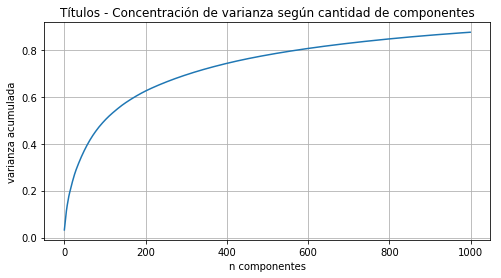

CPU times: user 1min 27s, sys: 27.8 s, total: 1min 55s
Wall time: 44.8 s


In [19]:
%%time
from sklearn.decomposition import TruncatedSVD#, IncrementalPCA, PCA
# Veo con 1000 componentes como es la varianza
svd = TruncatedSVD(n_components=1000)
%time svd.fit(X)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('Títulos - Concentración de varianza según cantidad de componentes')
plt.xlabel('n componentes')
plt.ylabel('varianza acumulada')
plt.grid()
plt.show()

In [20]:
print('Veo que con 500 features abarco el 75% de la varianza')
svd = TruncatedSVD(n_components=500)
%time X = svd.fit_transform(X)
print(X.shape)
del(svd)

Veo que con 500 features abarco el 75% de la varianza
CPU times: user 30.1 s, sys: 14.6 s, total: 44.7 s
Wall time: 15.6 s
(19679, 500)


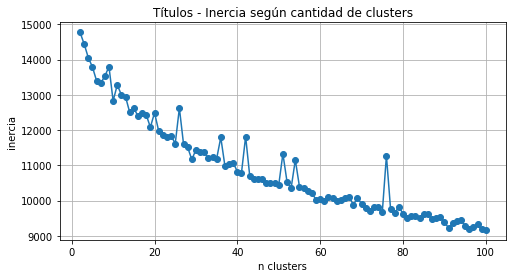

CPU times: user 6min 3s, sys: 7min 53s, total: 13min 57s
Wall time: 3min 39s


In [21]:
%%time
from sklearn.cluster import MiniBatchKMeans
# probando pocos clusters no puede verse un "codo"
clusters = range(2,101)
costs = []
for n_clusters in clusters:
  model = MiniBatchKMeans(n_clusters=n_clusters)
  model.fit(X)
  costs.append(model.inertia_)
plt.figure(figsize=(8,4))
plt.plot(clusters, costs, marker='o')
plt.grid(True)
plt.title('Títulos - Inercia según cantidad de clusters')
plt.xlabel('n clusters')
plt.ylabel('inercia')
plt.show()

In [22]:
# tomo 20 clusters
model = MiniBatchKMeans(n_clusters=60)
model.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=60,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [23]:
titulos_dummies = pd.get_dummies(model.labels_)
titulos_dummies.rename(columns=dict([(n,f'titulo_{n+1}') for n in range(len(titulos_dummies.columns))]), inplace=True)
avisos = pd.merge(avisos,titulos_dummies, left_index=True, right_index=True).drop(columns=['titulo'])
print(avisos.shape)
avisos.tail(3)

(19679, 126)


,idaviso,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,desc_1,desc_2,desc_3,desc_4,...,titulo_51,titulo_52,titulo_53,titulo_54,titulo_55,titulo_56,titulo_57,titulo_58,titulo_59,titulo_60
19676,1112408026,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Almacén / Depósito / Expedición,CastelnuovoRH,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19677,1112407951,Gran Buenos Aires,Full-time,Junior,Administración,Theorema,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19678,1112408032,Gran Buenos Aires,Full-time,Junior,Programación,CERUTTI & ASOCIADOS CONSULTING,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### EDADYGÉNERO

In [76]:
%%time
# EDADYGENERO
# Elimino filas con datos faltantes
if(edadYGenero.isna().any().any()):
  edadYGenero.dropna(inplace=True)
  edadYGenero.reset_index(drop=True, inplace=True)

# Convierto columnas con fechas a datetime
edadYGenero['fechanacimiento'] = pd.to_datetime(edadYGenero.fechanacimiento, format='%Y/%m/%d', errors='coerce')
if(edadYGenero.isna().any().any()):
  print(edadYGenero.isna().any())
  edadYGenero.dropna(inplace=True)
  edadYGenero.reset_index(drop=True, inplace=True)
  print()

# Agrego columna edad
anio_actual = pd.to_datetime('today').year
edadYGenero['edad'] = edadYGenero.fechanacimiento.map(lambda fecha: anio_actual - fecha.year).astype(int)

# Elimino la columna fechanacimiento
edadYGenero.drop(columns=['fechanacimiento'], inplace=True)

# Analizo los datos de la columna 'sexo'
print(edadYGenero.sexo.value_counts())
for value in edadYGenero.sexo.value_counts().index:
  if((value != 'FEM') & (value != 'MASC')):
    print(f'tasa [{value}]/total:',len(edadYGenero.sexo[edadYGenero.sexo == value])/len(edadYGenero))
print()

# Reemplazo esos valores por valor moda
moda = edadYGenero.sexo.mode()[0]
print('mode',moda)
edadYGenero.sexo.replace(['NO_DECLARA','0.0'], moda, inplace=True)
print(edadYGenero.sexo.value_counts())
print()

# Elimino filas con id duplicado
if(edadYGenero.idpostulante.duplicated().any()):
  print('total:',len(edadYGenero),'| duplicados:',len(edadYGenero[edadYGenero.idpostulante.duplicated()]))
  print('tasa:',len(edadYGenero[edadYGenero.idpostulante.duplicated()])/len(edadYGenero))
  edadYGenero.drop(edadYGenero[edadYGenero.idpostulante.duplicated()].index, inplace=True)
  edadYGenero.reset_index(drop=True, inplace=True)
  print('tamaño final: ', len(edadYGenero))

# Cambio valores categóricos
genero = {'FEM': 0,'MASC': 1}
edadYGenero['sexo'] = edadYGenero.sexo.map(lambda x: genero[x])
print()
edadYGenero.sample(3)

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool

FEM           204023
MASC          183814
NO_DECLARA       943
0.0                1
Name: sexo, dtype: int64
tasa [NO_DECLARA]/total: 0.002425530054195035
tasa [0.0]/total: 2.5721421571527415e-06

mode FEM
FEM     204967
MASC    183814
Name: sexo, dtype: int64

total: 388781 | duplicados: 146
tasa: 0.00037553275494430025
tamaño final:  388635

CPU times: user 4.99 s, sys: 16.7 ms, total: 5.01 s
Wall time: 5 s


### EDUCACIÓN

In [77]:
%%time
# EDUCACIÓN
# Analizo valores
nivel_counts = educacion.nivel.value_counts()
print('[nivel]')
for val in nivel_counts.index:
  print(val,' '*(17-len(val)),nivel_counts[val],' '*(7-len(str(nivel_counts[val]))),nivel_counts[val]/len(educacion))

# Reemplazo valor 'Otro' por valor moda
mode = educacion.nivel.mode()[0]
educacion.nivel.replace('Otro', mode, inplace=True)
print()
print('[estado]')
print(educacion.estado.value_counts())

# Convierto valores categóricos a columnas booleanas
nivel = {
  'Doctorado': 6,
   'Master': 5,
   'Posgrado': 4,
   'Universitario': 3,
   'Terciario/Técnico': 2,
   'Secundario': 1
  }
educacion['nivel'] = educacion.nivel.map(lambda x: nivel[x])

estado = {'Graduado': 3,'En Curso': 2, 'Abandonado': 1}
educacion['estado'] = educacion.estado.map(lambda x: estado[x])
print()
educacion.sample(3)

[nivel]
Universitario      207752   0.3653668934176556
Secundario         199375   0.35063452758647373
Terciario/Técnico  92632    0.1629089783543084
Otro               43225    0.07601844491498597
Posgrado           16822    0.029584321118794537
Master             8299     0.01459518968998192
Doctorado          507      0.0008916449177998354

[estado]
Graduado      370213
En Curso      149388
Abandonado     49011
Name: estado, dtype: int64

CPU times: user 1.09 s, sys: 10 ms, total: 1.1 s
Wall time: 1.09 s


In [78]:
educacion_grouped = educacion.groupby('idpostulante')

In [79]:
%%time
# Armo un nuevo df con ids únicos
# Busco para cada id el máximo nivel de estudio con estado "graduado"
max_niveles = []
for name, group in educacion_grouped:
  max_nivel = 0
  for i in group.index:
    if group.estado[i] == 3:
      if group.nivel[i] > max_nivel:
        max_nivel = group.nivel[i]
  max_niveles.append({'idpostulante': name, 'max_nivel_graduado': max_nivel})

usuarios_edu = pd.DataFrame(max_niveles)

# Ahora la cantidad de cantidad de estudios completados ("graduado")
usuarios_edu['cant_estudios_graduado'] = educacion_grouped.agg({'estado': lambda x: np.count_nonzero(x == 3)})\
                                                          .reset_index(drop=True)

CPU times: user 5min 4s, sys: 779 ms, total: 5min 4s
Wall time: 5min 5s


In [80]:
usuarios_edu.shape

(366395, 3)

In [ ]:
# Analizo las fechas de postulaciónes y vistas
fechas = pd.to_datetime(postulaciones.fechapostulacion)
print('[posts]', ' min:', fechas.min(), '| max:', fechas.max())
fechas = pd.to_datetime(vistas.fechavista)
print('[vistas]', 'min:', fechas.min(), '| max:', fechas.max())

In [ ]:
#vistas.groupby(['idpostulante','idaviso']).count()
vistas.loc[(vistas.idpostulante == '0zB026d') & (vistas.idaviso == 1112358250),:]

In [ ]:
# Unifico vistas y postulaciones
vistas_y_postulaciones = pd.merge(vistas, postulaciones, on=['idpostulante','idaviso'], how='outer')

# Renombro columnas y reordeno
vistas_y_postulaciones.rename(columns={'fechavista':'vista','fechapostulacion':'postulacion'}, inplace=True)
vistas_y_postulaciones = vistas_y_postulaciones[['idaviso','idpostulante','vista','postulacion']]

# Cambio valores de fechas por 1 si hay fecha y 0 si es NaN
vistas_y_postulaciones.vista = vistas_y_postulaciones.vista.notnull().astype('int')
vistas_y_postulaciones.postulacion = vistas_y_postulaciones.postulacion.notnull().astype('int')

In [ ]:
postulaciones.groupby(['idpostulante','idaviso']).count()[lambda x: x.fechapostulacion == 5]

In [ ]:
usr_pos = postulaciones.idpostulante.unique()
usr_info = edadYGenero.idpostulante.unique()
print(len(usr_pos),len(usr_info))